# Advaned Data Analysis

In [12]:
# Import required libraries
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns  # Importing Seaborn for visualization


In [13]:
from cleaning_preprocessing import preprocess_data, clean_data
from ML import split_data
from feature_engineering import perform_feature_engineering
import pandas as pd

In [21]:
# Load and clean data
df = pd.read_csv(r'churn.csv')
data = clean_data(df.copy())



**statistics for numeric columns**

In [22]:

def iqr(x):
    return np.percentile(x, 75) - np.percentile(x, 25)

num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [col for col in num_cols if col != 'churn_risk_score']

summary = data.groupby('churn_risk_score')[num_cols].agg(['mean', 'std', 'median', 'count', iqr])

summary


age                                 \
                       mean        std median  count   iqr   
churn_risk_score                                             
0                 37.012662  15.920910   37.0  16980  28.0   
1                 37.207675  15.821724   37.0  20012  27.0   

                 days_since_last_login                               ...  \
                                  mean       std median  count  iqr  ...   
churn_risk_score                                                     ...   
0                            12.675206  5.456140   13.0  16980  7.0  ...   
1                            12.853388  5.388323   13.0  20012  7.0  ...   

                 avg_frequency_login_days                                 \
                                     mean       std median  count    iqr   
churn_risk_score                                                           
0                               15.307100  7.899226   16.0  16980  10.25   
1                               17.470367  7.753620   16.0  20012  11.00   

                 points_in_wallet                                       
                             mean         std  median  count       iqr  
churn_risk_score                                                        
0                      748.744055  165.551032  749.43  16980   75.9850  
1                      642.223854  171.979198  648.75  20012  104.0725  

[2 rows x 30 columns]

**chi square**

In [23]:



# 1. Identifying categorical columns
categorical_cols = data.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['churn_risk_score']]  # Exclude non-relevant columns

# 2. Initializing a dictionary to store the results
chi_square_results = {}

# 3. Performing the Chi-Square Test
for col in categorical_cols:
    # Creating a contingency table between "churn_risk_score" and each categorical column
    contingency_table = pd.crosstab(data['churn_risk_score'], data[col]) 

    # Applying the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Storing the result (p-value) in the dictionary
    chi_square_results[col] = p

# 4. Converting the results into a DataFrame
chi_square_df = pd.DataFrame(list(chi_square_results.items()), columns=['Feature', 'p-value'])

# 5. Sorting the results by p-value
chi_square_df.sort_values('p-value', inplace=True)

# 6. Displaying the results
print(chi_square_df)

# 7. Filtering the results where p-value is less than 0.05
significant_categorical_features = chi_square_df[chi_square_df['p-value'] < 0.05]

print("\nSignificant features based on Chi-Square test (p-value < 0.05):")
print(significant_categorical_features)


                         Feature       p-value
2            membership_category  0.000000e+00
11                      feedback  0.000000e+00
4          preferred_offer_types  5.948122e-16
1                region_category  9.613296e-05
8   offer_application_preference  3.284632e-04
5            medium_of_operation  4.654710e-04
7          used_special_discount  4.160001e-02
9                 past_complaint  8.765362e-02
10              complaint_status  2.803956e-01
6                internet_option  3.286981e-01
0                         gender  3.714744e-01
3                   joining_date  8.146282e-01

Significant features based on Chi-Square test (p-value < 0.05):
                         Feature       p-value
2            membership_category  0.000000e+00
11                      feedback  0.000000e+00
4          preferred_offer_types  5.948122e-16
1                region_category  9.613296e-05
8   offer_application_preference  3.284632e-04
5            medium_of_operation  4.654710

**ANOVA**

In [24]:

from scipy import stats  # Importing stats from scipy
# Selecting the relevant columns and removing any rows with missing values
df_anova = data[['avg_transaction_value', 'membership_category']].dropna()

# Grouping the data by membership category
groups = df_anova.groupby('membership_category')['avg_transaction_value'].apply(list)

# Performing the ANOVA test
f_stat, p_value = stats.f_oneway(*groups)

# Printing the results
print("ANOVA Test:")
print("F-statistic:", f_stat)
print("P-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("There are significant differences between membership categories.")
else:
    print("There are no significant differences between membership categories.")


ANOVA Test:
F-statistic: 327.4290956119143
P-value: 0.0
There are significant differences between membership categories.


**T_test**

In [25]:
from scipy.stats import ttest_ind

# Removing rows with missing values
df_ttest = data[['points_in_wallet', 'past_complaint']].dropna()

# Stripping any extra spaces in the 'past_complaint' column values
df_ttest['past_complaint'] = df_ttest['past_complaint'].str.strip()

# Preparing the two groups
group_yes = df_ttest[df_ttest['past_complaint'] == 'Yes']['points_in_wallet']
group_no  = df_ttest[df_ttest['past_complaint'] == 'No']['points_in_wallet']

# Performing the T-Test
t_stat, p_value = ttest_ind(group_yes, group_no, equal_var=False)  # Welch’s T-test for unequal variances

# Printing the results
print("T-Test between points_in_wallet and past_complaint:")
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("=> There is a significant difference between the two groups.")
else:
    print("=> There is no significant difference between the two groups.")


T-Test between points_in_wallet and past_complaint:
T-Statistic: -0.5864344556211992
P-Value: 0.5575871742552968
=> There is no significant difference between the two groups.


**correlation matrix**


Correlation of variables with churn_risk_score (sorted):
avg_frequency_login_days    0.136550
days_since_last_login       0.016382
age                         0.006124
avg_time_spent             -0.012481
avg_transaction_value      -0.218012
points_in_wallet           -0.299567
Name: churn_risk_score, dtype: float64


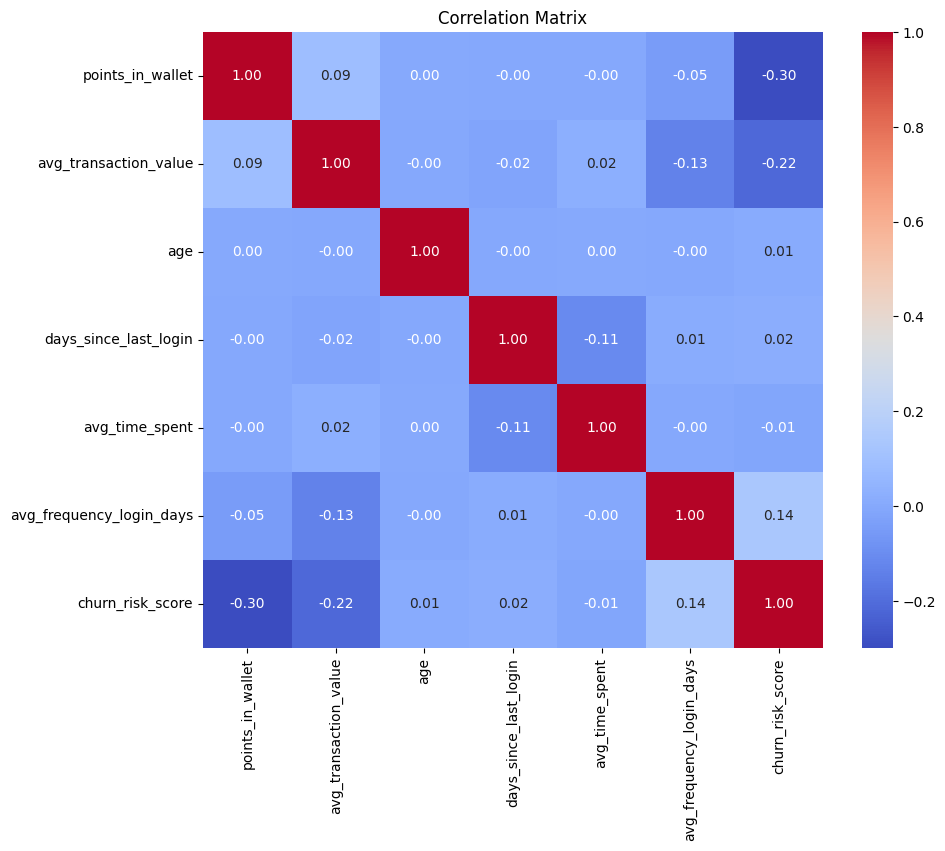

In [26]:

# Defining only the numerical variables
numerical_features = [
    'points_in_wallet',
    'avg_transaction_value',
    'age',
    'days_since_last_login',
    'avg_time_spent',
    'avg_frequency_login_days',
    'churn_risk_score'
]

# Creating the correlation matrix
corr_matrix = data[numerical_features].corr()

# Sorting correlation values with churn_risk_score
corr_with_target = corr_matrix['churn_risk_score'].drop('churn_risk_score').sort_values(ascending=False)

# Printing sorted correlation values
print("\nCorrelation of variables with churn_risk_score (sorted):")
print(corr_with_target)

# Plotting a heatmap to visualize the full correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [27]:
preprocessed_data = preprocess_data(data)
engineered_data = perform_feature_engineering(preprocessed_data)

**RFE**

In [28]:


data_rfe = engineered_data
for col in data_rfe.columns:
    if data_rfe[col].dtype == 'object' or data_rfe[col].dtype.name == 'datetime64[ns]':
        try:
            data_rfe[col] = pd.to_numeric(data_rfe[col])
        except:
            data_rfe = data_rfe.drop(col, axis=1)

X = data_rfe.drop('churn_risk_score', axis=1)
y = data_rfe['churn_risk_score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = 30

# 3. RFE : Random Forest
rf_model = RandomForestClassifier(random_state=42)
rfe_rf = RFE(rf_model, n_features_to_select=num_features)
rfe_rf.fit(X_train, y_train)
rf_selected_features = X.columns[rfe_rf.support_]

# 4. RFE : Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
rfe_lr = RFE(lr_model, n_features_to_select=num_features)
rfe_lr.fit(X_train, y_train)
lr_selected_features = X.columns[rfe_lr.support_]


# Random Forest performance
rf_model.fit(X_train[rf_selected_features], y_train)
y_pred_rf = rf_model.predict(X_test[rf_selected_features])
acc_rf = accuracy_score(y_test, y_pred_rf)

# Logistic Regression performance
lr_model.fit(X_train[lr_selected_features], y_train)
y_pred_lr = lr_model.predict(X_test[lr_selected_features])
acc_lr = accuracy_score(y_test, y_pred_lr)


print("\n Random Forest selected features:")
print(rf_selected_features.tolist())
print(f"Random Forest RFE Accuracy: {acc_rf:.4f}")

print("\n Logistic Regression selected features:")
print(lr_selected_features.tolist())
print(f"Logistic Regression RFE Accuracy: {acc_lr:.4f}")

common = set(rf_selected_features) & set(lr_selected_features)
only_rf = set(rf_selected_features) - set(lr_selected_features)
only_lr = set(lr_selected_features) - set(rf_selected_features)

print("\n Common Features:", list(common))
print(" Only in RF:", list(only_rf))
print(" Only in LR:", list(only_lr))



 Random Forest selected features:
['age', 'joining_date', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet', 'membership_category(Basic Membership)', 'membership_category(Gold Membership)', 'membership_category(No Membership)', 'membership_category(Platinum Membership)', 'membership_category(Premium Membership)', 'membership_category(Silver Membership)', 'feedback(Products always in Stock)', 'feedback(Quality Customer Care)', 'feedback(Reasonable Price)', 'feedback(User Friendly Website)', 'customer_tenure', 'usage_pattern', 'interaction_frequency', 'engagement_score', 'log_age', 'log_avg_time_spent', 'log_avg_transaction_value', 'log_avg_frequency_login_days', 'log_points_in_wallet', 'log_customer_tenure', 'log_usage_pattern', 'log_engagement_score', 'join_month']
Random Forest RFE Accuracy: 0.9339

 Logistic Regression selected features:
['age', 'joining_date', 'days_since_last_login', 'avg_time_spent', 'avg_transactio